# Unsupervised learning

In [1]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import pandas as pd

# seting master("local[*]") enables multicore processing on all available logical cores on your machine
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

# PCA example with diabetes dataset

In [3]:
# we will use pandas to display the data nicely
datasource = pd.read_csv('http://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', delimiter='\t')
datasource.columns = ['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu', 'disease_progression']
diabetes_df = spark.createDataFrame(datasource)

In [4]:
print("datasource:", datasource.shape)
diabetes_df

datasource: (442, 11)


DataFrame[age: bigint, sex: bigint, bmi: double, map: double, tc: bigint, ldl: double, hdl: double, tch: double, ltg: double, glu: bigint, disease_progression: bigint]

## Build a pipeline

In [5]:
pipeline_diabetes = Pipeline(stages=[
    # vector assembler concatenates the specified input cols into vectors in the specified output col 
    feature.VectorAssembler(inputCols=['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu'],
                           outputCol='features'),
    feature.StandardScaler(withMean=True,
                           inputCol='features', outputCol='zfeatures'),
    # build a principal component object with the same number of components as features (10)
    feature.PCA(k=10, inputCol='zfeatures', outputCol='scores')
]).fit(diabetes_df)

The `loadings` array are the loadings in ISLR equation 10.1.  The loadings are the coefficients in equation 10.1 that are used to perform the linear combination of column vectors in the dataset.  The linear combination of column vectors forms a principal component where each principal component captures a degree of variance in the data.  The first principal component captures the highest degree of variance, the 2nd principal component captures the next highest degree of variance in an orthoganal direction, etc.  <br> <br>
Each loading vector represents a specific direction in the data set's p dimensional space (where p is the number of features) which captures variance.  The direction of the loading vector associated with the first principal component represents the direction which captures the most variance in the data.  The loading vector associated with the 2nd principal component is orthogonal to the 1st component and captures the 2nd most varinace, etc.

In [6]:
loadings = pipeline_diabetes.stages[-1].pc.toArray()

In [83]:
print("loadings.shape", loadings.shape)

# print the first column of the loading array - the first principal component
print(loadings[:,0])

loadings.shape (10, 10)
[-0.2164309  -0.18696688 -0.30316216 -0.27173773 -0.34325511 -0.35186068
  0.28243681 -0.4288337  -0.37861802 -0.32218296]


The proportion of explained variance associated with each of the principal components is found in the explainedVariance attribute of the PCA object.  The explained variance shows the percentage of variance captured by each of the principal components.  For example, the first component captures 40.24 percent of the total variance in the diabetes dataset.  The 2nd component captures 14.92 percent of the total variance.

In [8]:
pipeline_diabetes.stages[-1].explainedVariance

DenseVector([0.4024, 0.1492, 0.1206, 0.0955, 0.0662, 0.0603, 0.0537, 0.0434, 0.0078, 0.0009])

Note that if we sum the explained variance vector that it sums to 1 (or 100%, or very very close to 100%).

In [9]:
sum(pipeline_diabetes.stages[-1].explainedVariance)

0.9999999999999998

The cell below generates a "scree polot" using the explainedVariance attribute.  See ISLR figure 10.4.

Text(0, 0.5, 'Proportion Variance Explained')

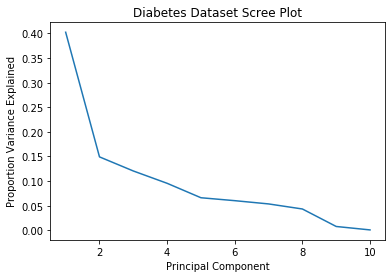

In [10]:
plt.figure()
explained_var = pipeline_diabetes.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("Diabetes Dataset Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

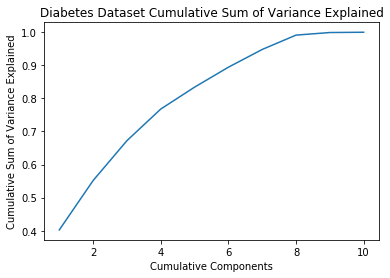

In [11]:
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Diabetes Dataset Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

Execute the diabetes pipeline and show the first row of standardized features and PCA scores.  The "scores" are like ISLR equation 10.2.  The scores are produced by projecting the data observations onto the loading vectors.  A projection is performed by multiplying the loading vector by the data observations which "projects" the observation in the direction of the loading vector. 

In [12]:
print(pipeline_diabetes.transform(diabetes_df).select('zfeatures', 'scores').take(1))
display(pipeline_diabetes.transform(diabetes_df).toPandas().head())

[Row(zfeatures=DenseVector([0.7996, 1.0643, 1.2956, 0.4593, -0.9287, -0.7312, -0.9114, -0.0544, 0.4181, -0.3706]), scores=DenseVector([-0.5865, -1.9446, 0.5885, 0.0827, 0.2564, -1.0101, -0.1796, 0.7566, 0.1809, 0.0489]))]


,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,disease_progression,features,zfeatures,scores
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151,"[59.0, 2.0, 32.1, 101.0, 157.0, 93.2, 38.0, 4....","[0.7995940351018838, 1.0642824935361896, 1.295...","[-0.5865345004628008, -1.9446286568771163, 0.5..."
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75,"[48.0, 1.0, 21.6, 87.0, 183.0, 103.2, 70.0, 3....","[-0.039522347083602145, -0.937474366646771, -1...","[2.8284203725740173, 1.3705287266001895, 0.027..."
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141,"[72.0, 2.0, 30.5, 93.0, 156.0, 93.6, 41.0, 4.0...","[1.7912770322301852, 1.0642824935361896, 0.933...","[-0.2718205368550441, -1.6330507612915226, 0.7..."
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206,"[24.0, 1.0, 25.3, 84.0, 198.0, 131.4, 40.0, 5....","[-1.8703217263973897, -0.937474366646771, -0.2...","[-0.04922536519991402, 0.3818453424540574, -2...."
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135,"[50.0, 1.0, 23.0, 101.0, 192.0, 125.4, 52.0, 4...","[0.11304426785921348, -0.937474366646771, -0.7...","[0.7555651902794538, 0.8110412184450315, -0.05..."


Assign the first row of standardized features to the variable `z`. 

In [13]:
z = pipeline_diabetes.transform(diabetes_df).select('zfeatures', 'scores').first()['zfeatures']
print(z)

[0.7995940351018838,1.0642824935361896,1.2956203368923545,0.4593200957947719,-0.9286934669133657,-0.7312360195916786,-0.911417758692523,-0.054437501961848156,0.41805720957971554,-0.37056862835587934]


The purpose of the next cell is to show that if we multiply the first loading vector by the first observation row we will obtain the same score which we extracted from the pipeline above.  The matrix dot product of a standardized observation with the loadings vector projects the observation onto the loading vector (see equation 10.2 in ISLR).  Also note that the resulting score is equal to the score for the first row computed by the pipeline above.

In [14]:
scores = z.dot(loadings[:,0])
print(scores)

-0.5865345004628009


In the next cell, we multiply the first observation row of the data by all of the loading vectors producing a score for each of the 10 principal components.  Note that the resulting array of scores is equal to the scores for the first row computed by the pipeline above.

In [15]:
scores = z.dot(loadings)
print(scores)

[-0.5865345  -1.94462866  0.58853858  0.08272184  0.25638973 -1.01006557
 -0.17964046  0.75657348  0.18087041  0.04889746]


In [16]:
num_loadings = loadings.shape[1]
for i in np.arange(4, num_loadings+1):
    print("num_loadings:", i)
    print(loadings[:,:i].dot(scores[:i]))

num_loadings: 4
[ 0.36604541  0.85469882  0.53897377  0.73214235 -0.94769719 -0.82510297
 -0.91662271  0.15941187  0.28857141  0.50989389]
num_loadings: 5
[ 0.54215325  0.75894648  0.5058142   0.60731275 -0.98081759 -0.85502933
 -0.97943845  0.19624122  0.32745007  0.50183738]
num_loadings: 6
[ 0.77024155  0.71682127  0.91302331  0.88284174 -0.98627012 -0.72042643
 -1.08686299  0.23051869  0.14692016 -0.31133202]
num_loadings: 7
[ 0.78991759  0.72896895  1.00641379  0.82523917 -0.99949948 -0.6790131
 -1.08550707  0.21772038  0.03063855 -0.24715244]
num_loadings: 8
[ 0.80121861  1.06408061  1.30368837  0.46408114 -0.90159063 -0.82376452
 -0.83989672  0.08109313  0.37085778 -0.37320364]
num_loadings: 9
[ 0.79975356  1.06446148  1.29602361  0.45916254 -0.89398727 -0.75877482
 -0.92694003 -0.05886742  0.40512549 -0.37044098]
num_loadings: 10
[ 0.79959404  1.06428249  1.29562034  0.4593201  -0.92869347 -0.73123602
 -0.91141776 -0.0544375   0.41805721 -0.37056863]


The cell below shows the dot product of all 10 loading vectors with the scores and is equivalent to when i == 10 above.

In [17]:
print(loadings.dot(scores))
print(loadings.shape)
print(scores.shape)

[ 0.79959404  1.06428249  1.29562034  0.4593201  -0.92869347 -0.73123602
 -0.91141776 -0.0544375   0.41805721 -0.37056863]
(10, 10)
(10,)


Note that the sum of the squares of the loading columns equal 1 as per ISLR equation 10.3.

In [18]:
np.sum(np.square(loadings), axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Examine the principal components

In [19]:
list(zip(['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu'], 
         loadings[:, 0], loadings[:, 1]))

[('age', -0.2164308964889745, 0.04436721239323424),
 ('sex', -0.18696687908602558, -0.38654720385516306),
 ('bmi', -0.30316216313887745, -0.15628128429437424),
 ('map', -0.2717377304844056, -0.13826600177995452),
 ('tc', -0.3432551083789176, 0.573026908841581),
 ('ldl', -0.3518606824177599, 0.45594185472401333),
 ('hdl', 0.28243681319974895, 0.5062390689011846),
 ('tch', -0.42883369801333127, -0.06818071604589006),
 ('ltg', -0.37861801599069916, -0.026186995954152716),
 ('glu', -0.32218295508497025, -0.08494884202867264)]

# Analysis of IM courses

In [20]:
im_courses = spark.createDataFrame(pd.read_csv('https://github.com/daniel-acuna/data_science_programs/raw/master/data/im_masters_ischool.csv'))

In [21]:
im_courses.show()

+-------+----+-------+--------------------+--------------------+
| course|core|credits|               title|         description|
+-------+----+-------+--------------------+--------------------+
|IST 553|  IM|      3|Information Archi...|Building and mana...|
|IST 558| CAS|      3|Technologies in W...|Concepts and tech...|
|IST 565| CAS|      3|         Data Mining|Introduction to d...|
|IST 601|  IM|      3|Information and I...|A broad overview ...|
|IST 614|  IM|      3|Management Princi...|Basic ideas, conc...|
|IST 617|  IM|      3|Motivational Aspe...|Theories of motiv...|
|IST 618|  IM|      3|  Information Policy|Public policy iss...|
|IST 619|  IM|      3|Applied Economics...|Economic principl...|
|IST 621|  IM|      3|Introduction to I...|Overview of gener...|
|IST 631|  IM|      3|Theory of Classif...|Classification is...|
|IST 639|  IM|      3|Enterprise Techno...|Coverage of manag...|
|IST 641|  IM|      3|   User-Based Design|System design bas...|
|IST 645|  IM|      3|Man

## Let's transform course descriptions into vectors

In [22]:
tokenizer = feature.RegexTokenizer(minTokenLength=2)\
  .setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("description")\
  .setOutputCol("words")

import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

sw_filter = feature.StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

cv = feature.CountVectorizer(inputCol='filtered', outputCol='tf')
idf = feature.IDF(inputCol='tf', outputCol='tfidf')

The rest of the functions do not work with Sparse vectors. We need to create a UDF that performs a sparse to dense transformation

Let's create a pipeline that transforms descriptions into TFIDF:

In [23]:
tfidf = Pipeline(stages=[tokenizer, sw_filter, cv, idf]).fit(im_courses)

In [24]:
tfidf.transform(im_courses).toPandas().head()

,course,core,credits,title,description,words,filtered,tf,tfidf
0,IST 553,IM,3,Information Architecture for Internet Services,Building and management of Internet informatio...,"[building, and, management, of, internet, info...","[building, management, internet, information, ...","(4.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.8572224325243911, 1.444269434866395, 0.0, 0..."
1,IST 558,CAS,3,Technologies in Web Content Management,Concepts and techniques in web content represe...,"[concepts, and, techniques, in, web, content, ...","[concepts, techniques, web, content, represent...","(0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.7221347174331975, 1.252762968495368, 1..."
2,IST 565,CAS,3,Data Mining,"Introduction to data mining techniques, famili...","[introduction, to, data, mining, techniques, f...","[introduction, data, mining, techniques, famil...","(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 1.252762968495368, 1.07044141170141..."
3,IST 601,IM,3,Information and Information Environments,A broad overview of the field and an orientati...,"[broad, overview, of, the, field, and, an, ori...","[broad, overview, field, orientation, school, ...","(2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.9286112162621956, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,IST 614,IM,3,Management Principles for Information Professi...,"Basic ideas, concepts and perspectives of mana...","[basic, ideas, concepts, and, perspectives, of...","[basic, ideas, concepts, perspectives, managem...","(1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","(0.4643056081310978, 0.7221347174331975, 0.0, ..."


We need to define a *Python* function that takes as input a `tfidf` column and then returns the dense version of it.
If we get the first row of the transformation, we can examine the type of `tfidf`

In [25]:
tfidf_sample = tfidf.transform(im_courses).first().tfidf
tfidf_sample

SparseVector(357, {0: 1.8572, 1: 1.4443, 9: 3.2189, 10: 1.6094, 14: 1.7636, 18: 1.7636, 43: 2.1691, 52: 2.1691, 54: 2.1691, 97: 2.4567, 120: 2.4567, 131: 5.7244, 283: 2.8622, 288: 2.8622, 302: 2.8622})

In [26]:
type(tfidf_sample)

pyspark.ml.linalg.SparseVector

We need to define a function that returns a dense version. For that, we will make use of the Vectors class

In [27]:
from pyspark.ml.linalg import Vectors

In [28]:
Vectors.dense(tfidf_sample)

DenseVector([1.8572, 1.4443, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2189, 1.6094, 0.0, 0.0, 0.0, 1.7636, 0.0, 0.0, 0.0, 1.7636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.7244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [29]:
type(Vectors.dense(tfidf_sample))

pyspark.ml.linalg.DenseVector

We need to work with `pyspark.ml.linalg.DenseVector` because that's what Spark ML expects (as opposed to a Numpy array or a pyspark sparse vector)

So, let's define the function:

In [30]:
def to_dense(sparse_vector):
    return Vectors.dense(sparse_vector)

In [31]:
to_dense(tfidf_sample)

DenseVector([1.8572, 1.4443, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2189, 1.6094, 0.0, 0.0, 0.0, 1.7636, 0.0, 0.0, 0.0, 1.7636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.7244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

Now, to define a user defined custom function (UDF) for Spark SQL, we need to provide the **return** type of the function to the constructor in `functions.udf`. The return type of `to_dense` is `VectorUDT` defined in `pyspark.ml.linalg.VectorUDT`

In [32]:
from pyspark.ml.linalg import VectorUDT

In [33]:
to_dense_udf = fn.udf(to_dense, VectorUDT())

Now we can use this function as part of our transformations

In [34]:
tfidf.transform(im_courses).select('tfidf', to_dense_udf('tfidf').alias('dense_tfidf')).show()

+--------------------+--------------------+
|               tfidf|         dense_tfidf|
+--------------------+--------------------+
|(357,[0,1,9,10,14...|[1.85722243252439...|
|(357,[1,2,3,4,14,...|[0.0,0.7221347174...|
|(357,[2,3,8,21,26...|[0.0,0.0,1.252762...|
|(357,[0,20,45,56,...|[0.92861121626219...|
|(357,[0,1,3,4,7,1...|[0.46430560813109...|
|(357,[0,1,6,10,24...|[1.39291682439329...|
|(357,[0,4,11,12,2...|[0.92861121626219...|
|(357,[0,1,4,5,16,...|[1.39291682439329...|
|(357,[0,1,4,56,59...|[0.46430560813109...|
|(357,[0,19,31,65,...|[0.46430560813109...|
|(357,[1,5,11,23,2...|[0.0,0.7221347174...|
|(357,[0,6,7,10,14...|[0.92861121626219...|
|(357,[0,1,7,8,16,...|[0.46430560813109...|
|(357,[0,6,15,17,1...|[0.46430560813109...|
|(357,[1,5,11,21,3...|[0.0,0.7221347174...|
|(357,[1,3,4,5,8,9...|[0.0,0.7221347174...|
|(357,[0,1,6,9,33,...|[0.46430560813109...|
|(357,[0,5,6,23,26...|[0.92861121626219...|
|(357,[0,1,2,3,4,5...|[0.46430560813109...|
|(357,[0,3,8,29,53...|[1.3929168

Moreover, we want to make this as part of a Pipeline. This is somewhat obscure and undocumented Spark functionality. We will now define a simple `Transformer` object that will apply the `to_dense_udf` to an input column as part of a Transformer object.

In [35]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

class Densify(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, stopwords=None):
        super(Densify, self).__init__()
        self._setDefault()
#         print(self._input_kwargs)
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, to_dense_udf(in_col))

The cell below creates a `Densify` transformer object that can be used in a Spark pipeline.

In [36]:
dense_tfidf = Densify(inputCol='tfidf', outputCol='dense_tfidf')

The cell below uses the `dense_tfidf` transformer in a pipeline.

In [37]:
pipeline2_model = Pipeline(stages=[tokenizer, sw_filter, cv, idf, dense_tfidf]).fit(im_courses)
pipeline2_model.transform(im_courses).select('tfidf', 'dense_tfidf').show()

+--------------------+--------------------+
|               tfidf|         dense_tfidf|
+--------------------+--------------------+
|(357,[0,1,8,12,14...|[1.85722243252439...|
|(357,[1,2,3,5,14,...|[0.0,0.7221347174...|
|(357,[2,3,9,22,24...|[0.0,0.0,1.252762...|
|(357,[0,26,42,61,...|[0.92861121626219...|
|(357,[0,1,3,5,6,1...|[0.46430560813109...|
|(357,[0,1,7,12,20...|[1.39291682439329...|
|(357,[0,5,10,11,3...|[0.92861121626219...|
|(357,[0,1,4,5,16,...|[1.39291682439329...|
|(357,[0,1,5,42,45...|[0.46430560813109...|
|(357,[0,19,33,89,...|[0.46430560813109...|
|(357,[1,4,11,22,2...|[0.0,0.7221347174...|
|(357,[0,6,7,12,14...|[0.92861121626219...|
|(357,[0,1,6,9,13,...|[0.46430560813109...|
|(357,[0,7,13,15,1...|[0.46430560813109...|
|(357,[1,4,11,25,3...|[0.0,0.7221347174...|
|(357,[1,3,4,5,8,9...|[0.0,0.7221347174...|
|(357,[0,1,7,8,35,...|[0.46430560813109...|
|(357,[0,4,7,22,24...|[0.92861121626219...|
|(357,[0,1,2,3,4,5...|[0.46430560813109...|
|(357,[0,3,9,30,43...|[1.3929168

The cell below defines a standard scaler object which will be used to standardize data before applying unsupervised learning algorithms.

In [38]:
# standardize features - it doesn't work in Spark 2.1
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='dense_tfidf', outputCol='centered_tfidf')

In the cell below we define a PCA transformer.  PCA needs the number of principal components to be learned `k`:

In [39]:
pca = feature.PCA(k=10, inputCol='centered_tfidf', outputCol='pca_feat')

For KMeans, we need to provide the number of clusters, but we will normalize the vectors so that they have unit length.  The cell below defines a `Normalizer` transformer which will normalize vectors to unit length.

In [40]:
norm = feature.Normalizer(inputCol="centered_tfidf", outputCol="norm_tfidf", p=2.0)

The cell below defines a Spark KMeans clustering object.

In [41]:
kmeans = clustering.KMeans(k=5, featuresCol='norm_tfidf', predictionCol='kmeans_feat')

#### Note - we will not be covering Latent Dirichlet Allocation (LDA) this semester - LDA can be skipped

Latent Dirichlet Allocation needs the number of topics and acts on raw tfidf:

In [42]:
lda = clustering.LDA(k=5, featuresCol='tfidf', topicDistributionCol='lda_feat')

In [43]:
pipeline = Pipeline(stages=[tokenizer, sw_filter, cv, idf, dense_tfidf, center, norm, kmeans, lda, pca])

In [44]:
pipeline_model = pipeline.fit(im_courses)

In [45]:
pipeline_model.transform(im_courses).toPandas().head()

,course,core,credits,title,description,words,filtered,tf,tfidf,dense_tfidf,centered_tfidf,norm_tfidf,kmeans_feat,lda_feat,pca_feat
0,IST 553,IM,3,Information Architecture for Internet Services,Building and management of Internet informatio...,"[building, and, management, of, internet, info...","[building, management, internet, information, ...","(4.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...","(1.8572224325243911, 1.444269434866395, 0.0, 0...","[1.8572224325243911, 1.444269434866395, 0.0, 0...","[1.3929168243932932, 1.0407235633596081, -0.55...","[0.13872833235603055, 0.10365144699245783, -0....",2,"[0.004123210676472138, 0.004221699712775576, 0...","[-0.6752213340342722, -0.578543526841376, 0.07..."
1,IST 558,CAS,3,Technologies in Web Content Management,Concepts and techniques in web content represe...,"[concepts, and, techniques, in, web, content, ...","[concepts, techniques, web, content, represent...","(0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.7221347174331975, 1.252762968495368, 1...","[0.0, 0.7221347174331975, 1.252762968495368, 1...","[-0.46430560813109784, 0.3185888459264106, 0.7...","[-0.0366053111174823, 0.025117172007974302, 0....",0,"[0.10911970806649235, 0.0026184934238192826, 0...","[-1.05600921972319, -0.16173650604120124, -1.7..."
2,IST 565,CAS,3,Data Mining,"Introduction to data mining techniques, famili...","[introduction, to, data, mining, techniques, f...","[introduction, data, mining, techniques, famil...","(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.252762968495368, 1.07044141170141...","[0.0, 0.0, 1.252762968495368, 1.07044141170141...","[-0.46430560813109784, -0.40354587150678684, 0...","[-0.039878871417135926, -0.03466026177351561, ...",4,"[0.34385937728479166, 0.0030246822808073863, 0...","[0.19618219422530014, -0.3954758666709434, -0...."
3,IST 601,IM,3,Information and Information Environments,A broad overview of the field and an orientati...,"[broad, overview, of, the, field, and, an, ori...","[broad, overview, field, orientation, school, ...","(2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.9286112162621956, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9286112162621956, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4643056081310977, -0.40354587150678684, -0....","[0.05153103151601464, -0.04478760251567384, -0...",2,"[0.9773807751717845, 0.005439320982915274, 0.0...","[-0.682379184988884, -0.07779816332342586, -0...."
4,IST 614,IM,3,Management Principles for Information Professi...,"Basic ideas, concepts and perspectives of mana...","[basic, ideas, concepts, and, perspectives, of...","[basic, ideas, concepts, perspectives, managem...","(1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","(0.4643056081310978, 0.7221347174331975, 0.0, ...","[0.4643056081310978, 0.7221347174331975, 0.0, ...","[-5.551115123125783e-17, 0.3185888459264106, -...","[-4.7440082817341044e-18, 0.027226747960001838...",0,"[0.0030948447421712075, 0.003169136065015298, ...","[-1.3508184757797228, -0.2786365081125683, -0...."


In [46]:
# note: pca_feat col is the PCA loadings
pipeline_model.transform(im_courses).select('course', 'pca_feat', 'kmeans_feat', 'lda_feat').show()

+-------+--------------------+-----------+--------------------+
| course|            pca_feat|kmeans_feat|            lda_feat|
+-------+--------------------+-----------+--------------------+
|IST 553|[-0.6752213340342...|          2|[0.00412321067647...|
|IST 558|[-1.0560092197231...|          0|[0.10911970806649...|
|IST 565|[0.19618219422530...|          4|[0.34385937728479...|
|IST 601|[-0.6823791849888...|          2|[0.97738077517178...|
|IST 614|[-1.3508184757797...|          0|[0.00309484474217...|
|IST 617|[-1.0011668423934...|          2|[0.00315293935360...|
|IST 618|[0.07015134336408...|          1|[0.00225739615110...|
|IST 619|[-0.8783462827126...|          0|[0.00309537201420...|
|IST 621|[-0.6168769630890...|          2|[0.00462955145624...|
|IST 631|[-1.1184062933773...|          2|[0.98482819545141...|
|IST 639|[8.23698193178384...|          2|[0.00227679153441...|
|IST 641|[-2.1217616801297...|          2|[0.00280494324485...|
|IST 645|[-1.6269837851599...|          

# Interpreation

We can examine the PCA loadings:

In [47]:
import pandas as pd

In [48]:
pipeline_model.stages

[RegexTokenizer_9e77c18c31e8,
 StopWordsRemover_881ef9af5ce8,
 CountVectorizer_1070039780d5,
 IDF_fafeeebf42c0,
 Densify_e4856e9a16b4,
 StandardScaler_27050ce4d0da,
 Normalizer_c118dbbeb5a1,
 KMeans_c7ce074906be,
 LDA_43c67c47959b,
 PCA_64cd20ca0cf4]

In [49]:
pca_model = pipeline_model.stages[-1]

In [50]:
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc2 = pca_model.pc.toArray()[:, 1].tolist()
pc3 = pca_model.pc.toArray()[:, 2].tolist()

In [51]:
vocabulary = pipeline_model.stages[2].vocabulary

In [52]:
pc_loadings = pd.DataFrame([vocabulary, pc1, pc2, pc3]).T.rename(columns={0: 'word', 
                                                                          1: 'load_pc1',
                                                                          2: 'load_pc2',
                                                                          3: 'load_pc3',})
print(pc_loadings.shape)

(357, 4)


Show the smallest and largest loadings

In [53]:
# smallest and biggest loadings of pc1
pd.concat((pc_loadings.sort_values('load_pc1').head(), 
           pc_loadings.sort_values('load_pc1').tail()))

,word,load_pc1,load_pc2,load_pc3
51,required,-0.067063,-0.0054385,-0.0715218
32,processing,-0.0654304,-0.00737648,-0.0743025
62,linguistic,-0.0613542,-0.00504601,-0.0764562
69,computational,-0.0613542,-0.00504601,-0.0764562
6,students,-0.0579638,-0.00405441,-0.0680286
79,architecture,0.188491,0.051103,-0.00445523
106,complex,0.188491,0.051103,-0.00445523
46,enterprise,0.254813,0.453853,0.0290984
28,databases,0.275076,-0.199085,-0.0735311
22,database,0.538651,-0.366988,-0.0595601


In [54]:
# smallest and biggest loadings of pc2
pd.concat((pc_loadings.sort_values('load_pc2').head(), 
           pc_loadings.sort_values('load_pc2').tail()))

,word,load_pc1,load_pc2,load_pc3
22,database,0.538651,-0.366988,-0.0595601
28,databases,0.275076,-0.199085,-0.0735311
116,warehouses,0.116554,-0.097372,-0.0149755
130,security,0.116207,-0.094556,0.129068
178,forms,0.134663,-0.091747,-0.01489
204,comprise,0.0849375,0.151284,0.00969948
5,systems,0.0903704,0.160692,-0.0276732
31,large,0.144783,0.263025,0.0181318
110,computing,0.169875,0.302568,0.019399
46,enterprise,0.254813,0.453853,0.0290984


In [55]:
# smallest and biggest loadings of pc3
pd.concat((pc_loadings.sort_values('load_pc3').head(), 
           pc_loadings.sort_values('load_pc3').tail()))

,word,load_pc1,load_pc2,load_pc3
42,metadata,-0.0223883,0.0428104,-0.194214
2,data,0.0864014,-0.0851734,-0.133236
50,projects,-0.0324584,0.0187311,-0.0871006
25,modeling,0.00457799,-0.00875369,-0.0798089
128,administration,0.0155463,-0.00854415,-0.079552
200,expression,0.000723382,-0.0184146,0.165259
313,library,0.000723382,-0.0184146,0.165259
38,economic,-0.0149275,-0.0125956,0.184823
94,public,0.00144676,-0.0368293,0.330519
82,policy,0.00144676,-0.0368293,0.330519


# Visualize fit with 2 dimensional PCA

In [56]:
pipeline2_model = Pipeline(stages=[tokenizer, sw_filter, cv, idf, dense_tfidf, 
                                   feature.Normalizer(inputCol='dense_tfidf', outputCol='norm_tfidf'), 
                                   feature.StandardScaler(withMean=True, withStd=False, 
                                                          inputCol='norm_tfidf',
                                                          outputCol='centered_tfidf'),
                                   feature.PCA(k=2, inputCol='centered_tfidf', outputCol='pca_feat2')])\
    .fit(im_courses)

In [57]:
course_names = np.array(im_courses.select('course').rdd.map(lambda x: x['course']).collect())
X = np.array(pipeline2_model.transform(im_courses).select('pca_feat2').rdd.map(lambda x: x['pca_feat2']).collect())

In [58]:
idx = np.abs(X[:, 0]) < 0.2
X = X[idx]
course_names = course_names[idx]

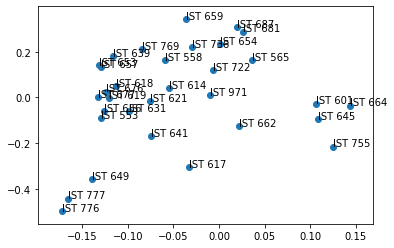

In [59]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])

for i, txt in enumerate(course_names):
    ax.annotate(txt, (X[i,0], X[i,1]))

In [60]:
pca_model = pipeline2_model.stages[-1]

In [61]:
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc2 = pca_model.pc.toArray()[:, 1].tolist()

In [62]:
vocabulary = pipeline2_model.stages[2].vocabulary

In [63]:
pc_loadings = pd.DataFrame([vocabulary, pc1, pc2]).T.rename(columns={0: 'word', 
                                                                     1: 'load_pc1',
                                                                     2: 'load_pc2'})

In [64]:
pc_loadings.sort_values('load_pc1').\
    apply({'word': lambda x: x, 'load_pc1': np.abs}, axis=0).head(5)

,word,load_pc1
16,research,0.11137
13,digital,0.0683895
6,design,0.0668912
11,issues,0.0572029
36,networks,0.0537774


In [65]:
pc_loadings.sort_values('load_pc2').\
    apply({'word': lambda x: x, 'load_pc2': np.abs}, axis=0).head(5)

,word,load_pc2
16,research,0.346353
51,user,0.175591
68,transfer,0.16139
125,procedures,0.154404
77,practices,0.141174


# Examine LDA

In [66]:
lda_model = pipeline_model.stages[-2]

In [67]:
lda_model.describeTopics(maxTermsPerTopic=2).show()

+-----+-----------+--------------------+
|topic|termIndices|         termWeights|
+-----+-----------+--------------------+
|    0|  [30, 125]|[0.02220123351045...|
|    1|  [112, 11]|[0.01422692714712...|
|    2|    [5, 57]|[0.01304006828722...|
|    3|    [97, 8]|[0.01955937503657...|
|    4|   [70, 36]|[0.02560311340179...|
+-----+-----------+--------------------+



In [68]:
# get the terms
terms_matrix = np.array(lda_model.describeTopics(2).rdd.map(lambda x: x['termIndices']).collect())

In [69]:
np.array(vocabulary)[terms_matrix]

array([['experience', 'procedures'],
       ['internet', 'issues'],
       ['concepts', 'principles'],
       ['quality', 'introduction'],
       ['models', 'networks']], dtype='<U18')

In [70]:
# which topic best describes IST 718
pipeline_model.transform(im_courses).where("course == 'IST 718'").first()['lda_feat']

DenseVector([0.0042, 0.0043, 0.0045, 0.0047, 0.9823])

# Examine K-means

In [71]:
pipeline_model.transform(im_courses).\
    groupBy('kmeans_feat').agg(fn.collect_list(
    fn.concat_ws('-', fn.col('course'), fn.col('title'))).alias('courses')).toPandas().values

array([[1,
        list(['IST 618-Information Policy', 'IST 645-Managing Information Systems Projects', 'IST 654-Information Systems Analysis', 'IST 664-Natural Language Processing', 'IST 722-Data Warehouse', 'IST 736-Text Mining'])],
       [3, list(['IST 681-Metadata'])],
       [4,
        list(['IST 565-Data Mining', 'IST 662-Instructional Strategies and Techniques for Information Professionals', 'IST 718-Advanced Information Analytics', 'IST 719-Information Visualization'])],
       [2,
        list(['IST 553-Information Architecture for Internet Services', 'IST 601-Information and Information Environments', 'IST 617-Motivational Aspects of Information Use', 'IST 621-Introduction to Information Management', 'IST 631-Theory of Classification and Subject Representation', 'IST 639-Enterprise Technologies', 'IST 641-User-Based Design', 'IST 649-Human Interaction with Computers', 'IST 653-Telecommunications and Enterprise Network Management I', 'IST 656-Telecommunications and Enterpris


# Make recommendations

To make recommendations, we need compute the distance between a vector and all the other courses in our dataset. To do this, we need to define a User Defined Function (UDF) that takes as input two column vectors and returns the distance between them.

In [72]:
from pyspark.sql import types

In [73]:
import numpy as np
def l2_dist(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))

Let's take the PCA features of IST 718.

In [74]:
l2_dist_udf = fn.udf(l2_dist, types.FloatType())

Spark doesn't allow a join without a condition because it could be too computationally expensive. We have to enable it by running the following command

In [75]:
spark.sql("SET spark.sql.crossJoin.enabled=TRUE").show()

+--------------------+-----+
|                 key|value|
+--------------------+-----+
|spark.sql.crossJo...| TRUE|
+--------------------+-----+



In [76]:
pipeline_model.transform(im_courses).\
    where('course == "IST 718"').\
    select(fn.col("pca_feat").alias('query_feat')).\
    join(pipeline_model.transform(im_courses)).\
    withColumn('dist', l2_dist_udf('pca_feat', 'query_feat')).\
    select("course", "description", "dist").\
    orderBy(fn.asc("dist")).\
    limit(5).\
    toPandas()

,course,description,dist
0,IST 718,A broad introduction to analytical processing ...,0.000000
1,IST 719,A broad introduction to data visualization for...,1.466475
2,IST 565,"Introduction to data mining techniques, famili...",4.206517
3,IST 662,Introduction to information literacy models fo...,4.281012
4,IST 601,A broad overview of the field and an orientati...,4.523474


To Do:  Create a biplot as part of this notebook

In [77]:
def biplot(score,coeff,score_labels=None, col_labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    plt.scatter(xs * scalex, ys * scaley, c = score_labels)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if col_labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, col_labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()